In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from itertools import chain
import json
from json import JSONDecodeError
import seaborn as sns
from scipy.stats import linregress
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel


def load_result(path):
    path = Path(path)
    try:
        with open(path / "results.json") as f:
            results = json.load(f)
        with open(path / "config.json") as f:
            config = json.load(f)
    except (FileNotFoundError, JSONDecodeError) as e:
        if isinstance(e, JSONDecodeError):
            print(f"Error decoding {path}: {e}")
        return
    
    if config["reporter"]["method"] == "ModularSftReporter":
        stages_cfg = config["reporter"]["stages"]
        weak_compute = sum(stage["num_weak_nonunique"] * stage["train_args"]["num_train_epochs"] for stage in stages_cfg)
        oracle_compute = sum(stage["num_oracle_nonunique"] * stage["train_args"]["num_train_epochs"] for stage in stages_cfg)
        total_compute = weak_compute + oracle_compute
    else:
        weak_compute, oracle_compute, total_compute = np.nan, np.nan, np.nan

    logodds = np.array(results["calibrated_logodds"])
    labels = np.array(results["gt_soft_labels"]) > 0.5
    thresh = np.quantile(logodds, labels.mean())
    calibrated_acc = ((logodds > thresh) == labels).mean()

    num_weak = results["reporter"]["num_weak"]
    num_oracle = results["reporter"]["num_oracle"]
    num_weak_nonunique = results["reporter"]["num_weak_nonunique"]
    num_oracle_nonunique = results["reporter"]["num_oracle_nonunique"]
    
    seed = int(path.name.split("_")[-1].split("s")[-1])
    sweep_name = "_".join(path.name.split("_")[3:-1])
    return {
        "auroc": results["auroc"],
        "acc": results["acc"],
        "calibrated_acc": calibrated_acc,
        "model_name": config["model"]["name"],
        "num_oracle": num_oracle,
        "num_weak": num_weak,
        "num_oracle_nonunique": num_oracle_nonunique,
        "num_weak_nonunique": num_weak_nonunique,
        "weak_compute": weak_compute,
        "oracle_compute": oracle_compute,
        "total_compute": total_compute,
        "seed": seed,
        "ds_name": path.parent.name,
        "sweep_name": sweep_name,
        "path": str(path),
    }


def get_results_df(ds_names=None, sweep_names=None):
    if sweep_names is not None:
        patterns = [f"nw=*_{sweep_name}_s*" for sweep_name in sweep_names]
    else:
        patterns = [f"nw=*_*_s*"]
    results = []
    if ds_names is None:
        ds_names = [d.name for d in Path("results").iterdir() if d.is_dir()]
    for ds_name in ds_names:
        for subdir in chain(*[Path(f"results/{ds_name}").glob(pattern) for pattern in patterns]):
            try:
                if result := load_result(subdir):
                    results.append(result)
            except Exception as e:
                continue
    results_df = pd.DataFrame(results)
    results_df.set_index(["ds_name", "model_name", "sweep_name"], inplace=True, drop=False)
    return results_df


def find_result_by_n(results_df, n_weak, n_oracle, run_name, atol=0., rtol=0., verbose=True, metric="acc"):
    if run_name[2] == "2weak_prompt_*_sft_estop":
        curr_df = results_df.xs((run_name[0], run_name[1]), level=['ds_name', 'model_name'])    
        curr_df = curr_df[curr_df.sweep_name.isin([
            "2weak_prompt_weak_sft_estop",
            "2weak_prompt_oracle_sft_estop",
        ])]
    else:
        curr_df = results_df.xs(run_name, level=['ds_name', 'model_name', 'sweep_name'])
    curr_df = curr_df[np.isclose(curr_df["num_oracle"], n_oracle, atol=atol, rtol=rtol)]
    curr_df = curr_df[np.isclose(curr_df["num_weak"], n_weak, atol=atol, rtol=rtol)]
    if len(curr_df) == 0:
        if verbose:
            print(f"WARNING: {run_name} has no results for ({n_weak}, {n_oracle})")
        return None, None, 0
    # print(curr_df["seed"].values.tolist())
    return curr_df[metric].mean(), curr_df[metric].std(ddof=1), len(curr_df)

In [20]:
base_ds_names = [
    "boolq",
    "hellaswag",
    "sciq",
    "cola",
    "cosmos_qa",
    "quail",
    "social_i_qa",
]

weak_models = ["Qwen1.5-0.5B", "Qwen1.5-4B"]
weak_names = [f"{name}_{wm}" for name in base_ds_names for wm in weak_models]

strong_name = "meta-llama/Meta-Llama-3-8B"
results_df = get_results_df(ds_names=weak_names, sweep_names=None)

Error decoding results/boolq_Qwen1.5-0.5B/nw=99_no=99_m=Meta-Llama-3-8B_100_steps_for_both_s68: Expecting value: line 1 column 1 (char 0)
Error decoding results/boolq_Qwen1.5-0.5B/nw=99_no=9_m=Meta-Llama-3-8B_100_steps_for_both_s19: Expecting value: line 1 column 1 (char 0)


In [21]:
from datasets import load_from_disk
from sklearn.metrics import roc_auc_score

weak_models = ["Qwen1.5-0.5B", "Qwen1.5-4B"]
weak_names = [f"{name}_{wm}" for name in base_ds_names for wm in weak_models]

weak_accs = dict()
weak_aucs = dict()
for weak_name in weak_names:
    ds = load_from_disk(f"results/{weak_name}/weak_train")
    probs = np.array(ds["soft_pred"])[:, 1]
    labels = np.array(ds["hard_label"])
    auc = roc_auc_score(labels, probs)
    acc = ((probs > 0.5) == labels).mean()
    print(f"{weak_name}: {acc=:.3f} (n={len(ds)})")
    weak_aucs[weak_name] = float(auc)
    weak_accs[weak_name] = float(acc)


boolq_Qwen1.5-0.5B: acc=0.683 (n=7106)
boolq_Qwen1.5-4B: acc=0.813 (n=7106)
hellaswag_Qwen1.5-0.5B: acc=0.675 (n=39842)
hellaswag_Qwen1.5-4B: acc=0.880 (n=39842)
sciq_Qwen1.5-0.5B: acc=0.772 (n=10674)
sciq_Qwen1.5-4B: acc=0.880 (n=10674)
cola_Qwen1.5-0.5B: acc=0.739 (n=5056)
cola_Qwen1.5-4B: acc=0.783 (n=5056)
cosmos_qa_Qwen1.5-0.5B: acc=0.786 (n=23788)
cosmos_qa_Qwen1.5-4B: acc=0.867 (n=23788)
quail_Qwen1.5-0.5B: acc=0.713 (n=10226)
quail_Qwen1.5-4B: acc=0.811 (n=10226)
social_i_qa_Qwen1.5-0.5B: acc=0.791 (n=33402)
social_i_qa_Qwen1.5-4B: acc=0.865 (n=33402)


In [22]:
from datasets import load_from_disk
from sklearn.metrics import roc_auc_score

weak_accs = dict()
weak_aucs = dict()
for weak_name in weak_names:
    ds = load_from_disk(f"results/{weak_name}/weak_train")
    probs = np.array(ds["soft_pred"])[:, 1]
    labels = np.array(ds["hard_label"])
    auc = roc_auc_score(labels, probs)
    weak_aucs[weak_name] = float(auc)
    weak_accs[weak_name] = float(((probs > 0.5) == labels).mean())


# 

# Main figure broken down by dataset for appendix

n_weak=81920, n_oracle=0, n=0
n_weak=77830, n_oracle=409, n=0
n_weak=40960, n_oracle=4096, n=0
n_weak=4100, n_oracle=7782, n=0
n_weak=0, n_oracle=8192, n=2
n_weak=40960, n_oracle=0, n=0
n_weak=38920, n_oracle=204, n=2
n_weak=20480, n_oracle=2048, n=2
n_weak=2050, n_oracle=3891, n=2
n_weak=0, n_oracle=4096, n=2
n_weak=10240, n_oracle=0, n=2
n_weak=9730, n_oracle=51, n=2
n_weak=5120, n_oracle=512, n=2
n_weak=520, n_oracle=972, n=2
n_weak=0, n_oracle=1024, n=2
n_weak=2560, n_oracle=0, n=2
n_weak=2440, n_oracle=12, n=2
n_weak=1280, n_oracle=128, n=2
n_weak=130, n_oracle=243, n=2
n_weak=0, n_oracle=256, n=2
n_weak=640, n_oracle=0, n=2
n_weak=610, n_oracle=3, n=2
n_weak=320, n_oracle=32, n=2
n_weak=40, n_oracle=60, n=2
n_weak=0, n_oracle=64, n=2
n_weak=160, n_oracle=0, n=2
n_weak=160, n_oracle=0, n=2
n_weak=80, n_oracle=8, n=2
n_weak=10, n_oracle=15, n=2
n_weak=0, n_oracle=16, n=2
n_weak=80, n_oracle=0, n=0
n_weak=80, n_oracle=0, n=0
n_weak=40, n_oracle=4, n=0
n_weak=10, n_oracle=7, n=0
n_we

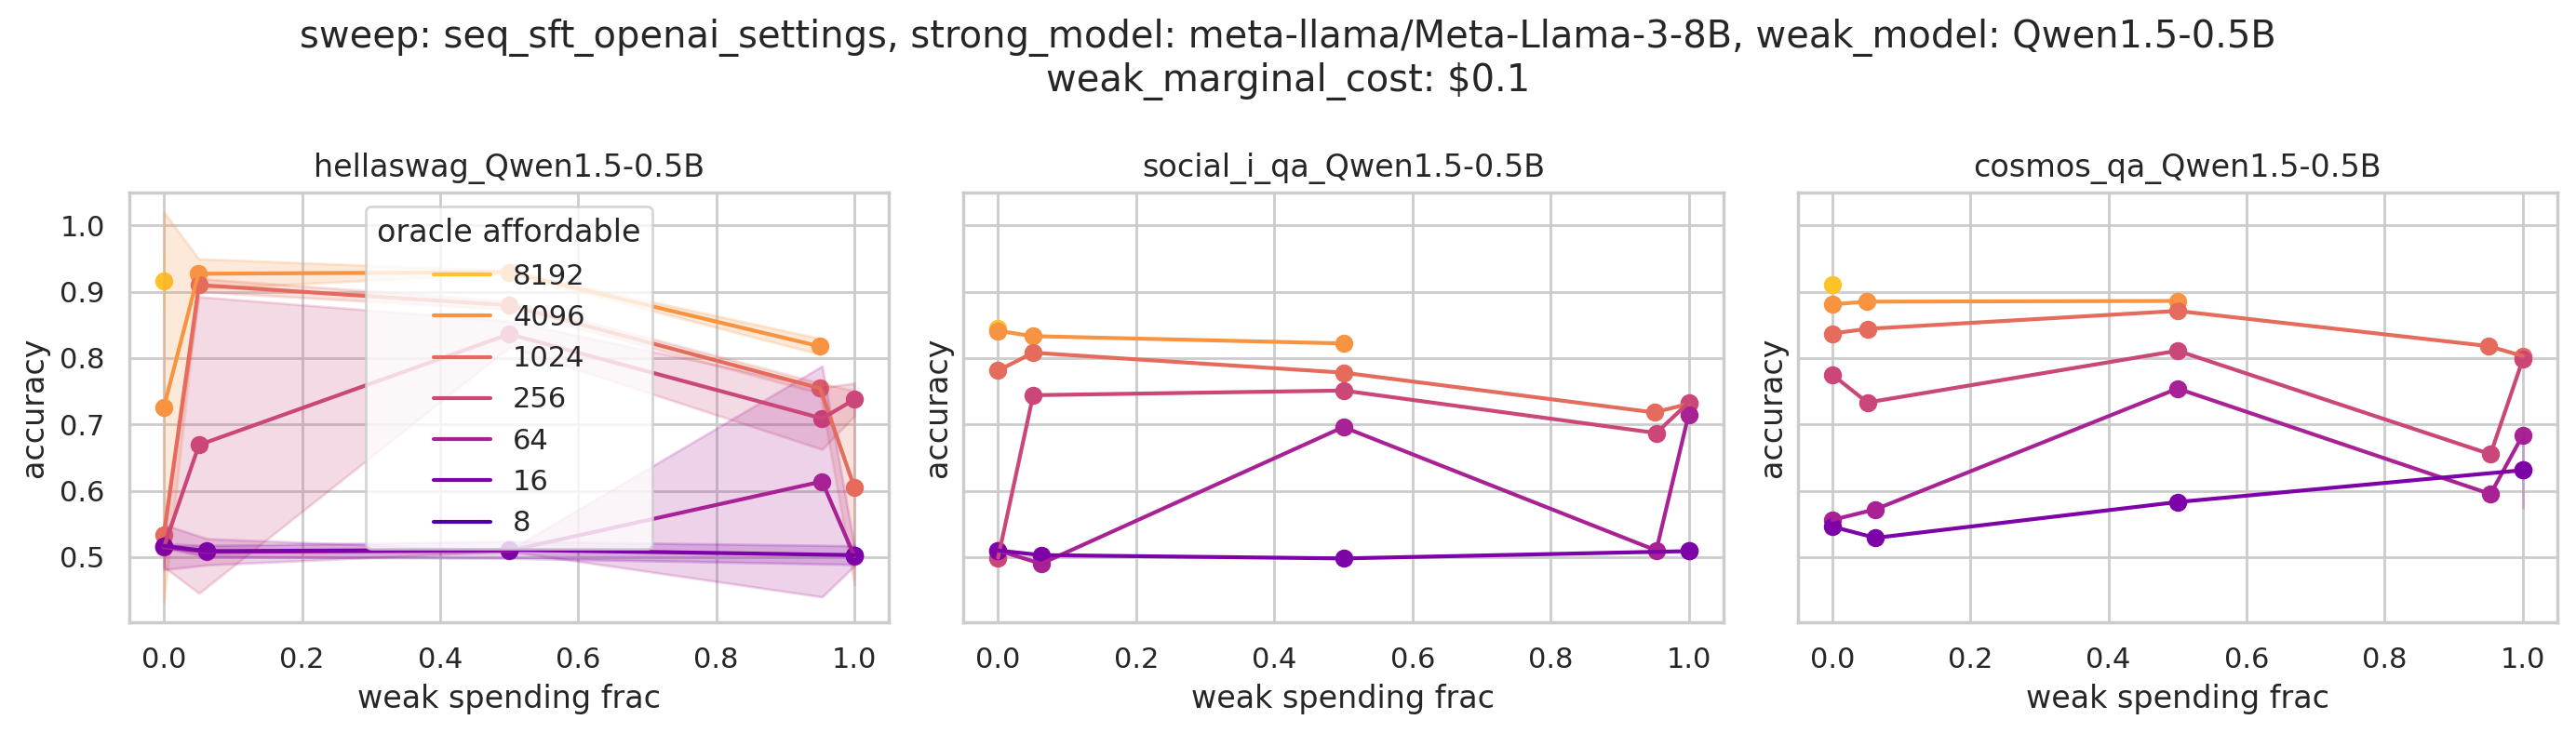

: 

In [30]:
sns.set_theme(style="whitegrid")

weak_marginal_cost = 1/10
weak_model = "Qwen1.5-0.5B"
strong_model = "meta-llama/Meta-Llama-3-8B"


# sweep_name = "seq_sft_both_estop_disjoint_logconf"
sweep_name = "seq_sft_openai_settings"
# sweep_name = "oracle_prompted_weak_sft_estop"
# sweep_name = "seq_sft_both_estop_active_oracle_disjoint"
# sweep_name = "seq_sft_both_estop_clean_disjoint"
weak_spending_fracs = [0.0, 0.05, 0.5, 0.95, 1.0]
oracle_affordables = [8, 16, 64, 256, 1024, 4096, 8192]
current_base_ds_names = ["hellaswag", "social_i_qa", "cosmos_qa"]

# sweep_name = "seq_sft_both_estop_clean_disjoint"
# weak_spending_fracs = [0.0, 0.05, 0.2, 0.4, 0.6, 0.8, 0.95, 1.0]
# oracle_affordables = [8, 16, 64, 256, 512, 1024, 4096, 8192]
# current_base_ds_names = base_ds_names

sns.set_palette("plasma_r", n_colors=len(oracle_affordables))
kinds = ["{base_name}_" + weak_model,]

fig, axs = plt.subplots(len(kinds), len(current_base_ds_names), figsize=(2 + 4 * len(current_base_ds_names), len(kinds) * 4), sharex=True, sharey=True, dpi=200)
axs = axs.reshape((-1, len(current_base_ds_names)))
for i, kind in enumerate(kinds):
    for j, base_ds_name in enumerate(current_base_ds_names):
        plt.sca(axs[i, j])
        ds_name = kind.format(base_name=base_ds_name)
        run_name = (ds_name,
            strong_model,
            sweep_name)
        
        # saliences = salience_df.loc[(ds_name, strong_model)]
        # salience_weak, salience_oracle = saliences["salience_weak"], saliences["salience_oracle"]
        
        for oracle_affordable in oracle_affordables[::-1]:
            accs = []
            acc_lo = []
            acc_hi = []
            actual_wsfs = []
            for wsf in weak_spending_fracs:
                osf = 1 - wsf
                n_oracle = int(wsf * oracle_affordable)
                n_weak = int((oracle_affordable - n_oracle) / weak_marginal_cost)
                acc, acc_std, n = find_result_by_n(results_df, n_weak, n_oracle, run_name, rtol=0.05, verbose=False)
                print(f"{n_weak=}, {n_oracle=}, {n=}")
                if acc is not None:
                    accs.append(acc)
                    acc_lo.append(acc - acc_std)
                    acc_hi.append(acc + acc_std)
                    actual_wsfs.append(1 - (n_oracle / (n_oracle + n_weak * weak_marginal_cost)))
                
            plt.plot(actual_wsfs, accs, label=f"{oracle_affordable}")
            plt.scatter(actual_wsfs, accs)
            plt.fill_between(actual_wsfs, acc_lo, acc_hi, alpha=0.2, color=plt.gca().lines[-1].get_color())
            
        plt.xlabel("weak spending frac")
        plt.ylabel("accuracy")
        plt.title(f"{ds_name}")
        if i == 0 and j == 0:
            plt.legend(title="oracle affordable")
plt.suptitle(f"sweep: {sweep_name}, strong_model: {strong_model}, weak_model: {weak_model}\nweak_marginal_cost: \\${weak_marginal_cost}")
plt.tight_layout()
plt.show()

In [ ]:
# plot the difference between wsf=0 and wsf=1
# for each cost
df = runs_df[runs_df["cost"] < 4096]
wsf1_df = df[df["weak_spending_frac"] == 1].sort_values(by="cost", ascending=False)
wsf0_df = df[df["weak_spending_frac"] == 0].sort_values(by="cost", ascending=False)
diff = wsf1_df["final_acc"].values - wsf0_df["final_acc"].values
plt.figure()
plt.plot(wsf1_df["cost"], diff)
plt.ylim(-0.5, 0.5)
plt.xlabel("cost")
plt.ylabel("difference in accuracy")
plt.show()

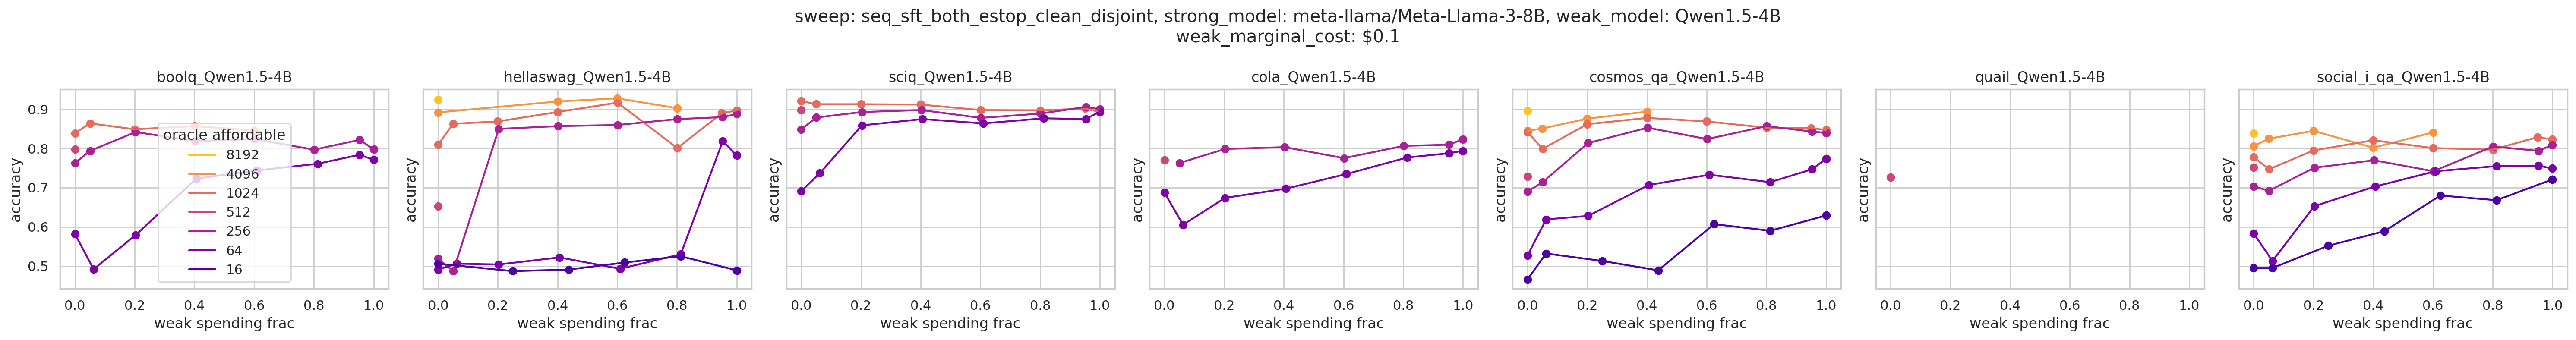

In [18]:
sns.set_theme(style="whitegrid")

weak_marginal_cost = 1/10
weak_model = "Qwen1.5-4B"
strong_model = "meta-llama/Meta-Llama-3-8B"


sweep_name = "seq_sft_both_estop_clean_disjoint"
weak_spending_fracs = [0.0, 0.05, 0.2, 0.4, 0.6, 0.8, 0.95, 1.0]
oracle_affordables = [16, 64, 256, 512, 1024, 4096, 8192]
sns.set_palette("plasma_r", n_colors=len(oracle_affordables))
current_base_ds_names = base_ds_names

kinds = ["{base_name}_" + weak_model,]

fig, axs = plt.subplots(len(kinds), len(current_base_ds_names), figsize=(2 + 4 * len(current_base_ds_names), len(kinds) * 4), sharex=True, sharey=True, dpi=200)
axs = axs.reshape((-1, len(current_base_ds_names)))
for i, kind in enumerate(kinds):
    for j, base_ds_name in enumerate(current_base_ds_names):
        plt.sca(axs[i, j])
        ds_name = kind.format(base_name=base_ds_name)
        run_name = (ds_name,
            strong_model,
            sweep_name)
        
        # saliences = salience_df.loc[(ds_name, strong_model)]
        # salience_weak, salience_oracle = saliences["salience_weak"], saliences["salience_oracle"]
        
        for oracle_affordable in oracle_affordables[::-1]:
            accs = []
            actual_wsfs = []
            for wsf in weak_spending_fracs:
                osf = 1 - wsf
                n_oracle = int(wsf * oracle_affordable)
                n_weak = int((oracle_affordable - n_oracle) / weak_marginal_cost)
                acc, acc_std, n = find_result_by_n(results_df, n_weak, n_oracle, run_name, rtol=0.05, verbose=False)
                if acc is not None:
                    accs.append(acc)
                    actual_wsfs.append(1 - (n_oracle / (n_oracle + n_weak * weak_marginal_cost)))
                
            plt.plot(actual_wsfs, accs, label=f"{oracle_affordable}")
            plt.scatter(actual_wsfs, accs)
            
        plt.xlabel("weak spending frac")
        plt.ylabel("accuracy")
        plt.title(f"{ds_name}")
        if i == 0 and j == 0:
            plt.legend(title="oracle affordable")
plt.suptitle(f"sweep: {sweep_name}, strong_model: {strong_model}, weak_model: {weak_model}\nweak_marginal_cost: \\${weak_marginal_cost}")
plt.tight_layout()
plt.show()

# Results averaged over datasets and seeds

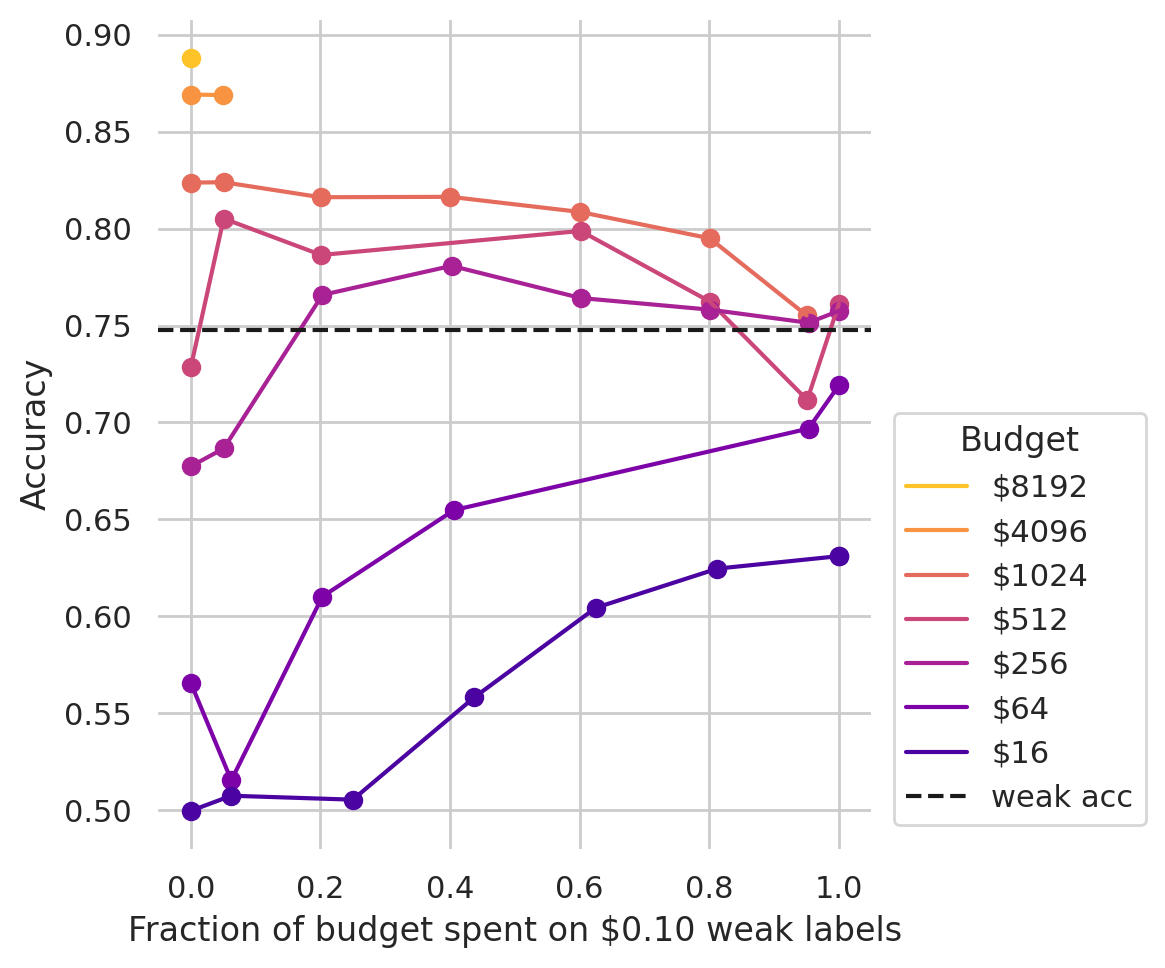

In [7]:
sns.set_theme(style="whitegrid")

metric = "acc"
weak_marginal_cost = 1/10
weak_model = "Qwen1.5-0.5B"
strong_model = "meta-llama/Meta-Llama-3-8B"

sweep_name = "seq_sft_both_estop_clean_disjoint"
weak_spending_fracs = [0.0, 0.05, 0.2, 0.4, 0.6, 0.8, 0.95, 1.0]
oracle_affordables = [16, 64, 256, 512, 1024, 4096, 8192]
sns.set_palette("plasma_r", n_colors=len(oracle_affordables))
current_base_ds_names = base_ds_names.copy()
current_base_ds_names.remove("boolq")
current_base_ds_names.remove("cola")


kind = "{base_name}_" + weak_model

fig, ax = plt.subplots(1, 1, figsize=(6, 5), sharex=True, sharey=True, dpi=200)
plt.sca(ax)

for oracle_affordable in oracle_affordables[::-1]:
    accs = []
    stds = []
    actual_wsfs = []
    for wsf in weak_spending_fracs:
        osf = 1 - wsf
        n_oracle = int(wsf * oracle_affordable)
        n_weak = int((oracle_affordable - n_oracle) / weak_marginal_cost)
        current_accs = []
        current_stds = []
        for j, base_ds_name in enumerate(current_base_ds_names):
            ds_name = kind.format(base_name=base_ds_name)
            run_name = (ds_name,
                strong_model,
                sweep_name)
            acc, std, n = find_result_by_n(results_df, n_weak, n_oracle, run_name, rtol=0.05, verbose=False, metric=metric)
            current_accs.append(acc)
            current_stds.append(std)
        if any(ca is None for ca in current_accs):
            continue
        accs.append(np.mean(current_accs))
        stds.append(np.std(current_accs))
        actual_wsfs.append(1 - (n_oracle / (n_oracle + n_weak * weak_marginal_cost)))
        
    plt.plot(actual_wsfs, accs, label=f"\\${oracle_affordable}")
    plt.scatter(actual_wsfs, accs)
    accs, stds = np.array(accs), np.array(stds)
    lo, hi = accs - stds, accs + stds
    # plt.fill_between(actual_wsfs, lo, hi, alpha=0.2)
    # plt.scatter(actual_wsfs[-1:], accs[-1:], s=50, marker="s", zorder=0,)

weak_acc = np.mean([weak_accs[f"{base_name}_{weak_model}"] for base_name in current_base_ds_names])
plt.axhline(weak_acc, color="k", linestyle="--", label=f"weak acc")
    
# turn off axis lines
plt.gca().spines['left'].set_color('none')
plt.gca().spines['bottom'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.xlabel(f"Fraction of budget spent on \\${weak_marginal_cost:.2f} weak labels")
plt.ylabel(metric.replace("calibrated_acc", "Calibrated Accuracy").replace("acc", "Accuracy"))
# plt.title(current_base_ds_names)
plt.legend(title="Budget", loc="lower left", bbox_to_anchor=(1.01, 0.01))
# plt.suptitle(f"sweep: {sweep_name}, strong_model: {strong_model}, weak_model: {weak_model}\nweak_marginal_cost: \\$$_g${weak_marginal_cost:.2f}")
plt.tight_layout()
plt.savefig(f"_figures/acc_vs_spending_frac.pdf", bbox_inches="tight")
plt.show()

# Pareto frontier figure

In [31]:
def get_pareto_points(costs, perfs, cost_rtol=0.01, perf_atol=0.002):
    # go from low cost to high cost. The cheapest point is on the paretor frontier.
    # Every time a new highest perf is observed, add it to the pareto frontier, 
    # unless there's something better within rtol cost of it
    pairs = sorted(list(zip(costs, perfs)), key=lambda x: (x[0], -x[1]))
    best_perf = pairs[0][1]
    frontier = [pairs[0]]
    for pair in pairs[1:]:
        if pair[1] <= best_perf + perf_atol:
            continue
        other_pairs = [p for p in pairs if p != pair]
        neighbors = [p for p in other_pairs if abs(p[0] - pair[0])/pair[0] <= cost_rtol]
        if all(p[1] < pair[1] for p in neighbors):
            frontier.append(pair)
            best_perf = pair[1]
    return tuple(map(list, zip(*frontier)))


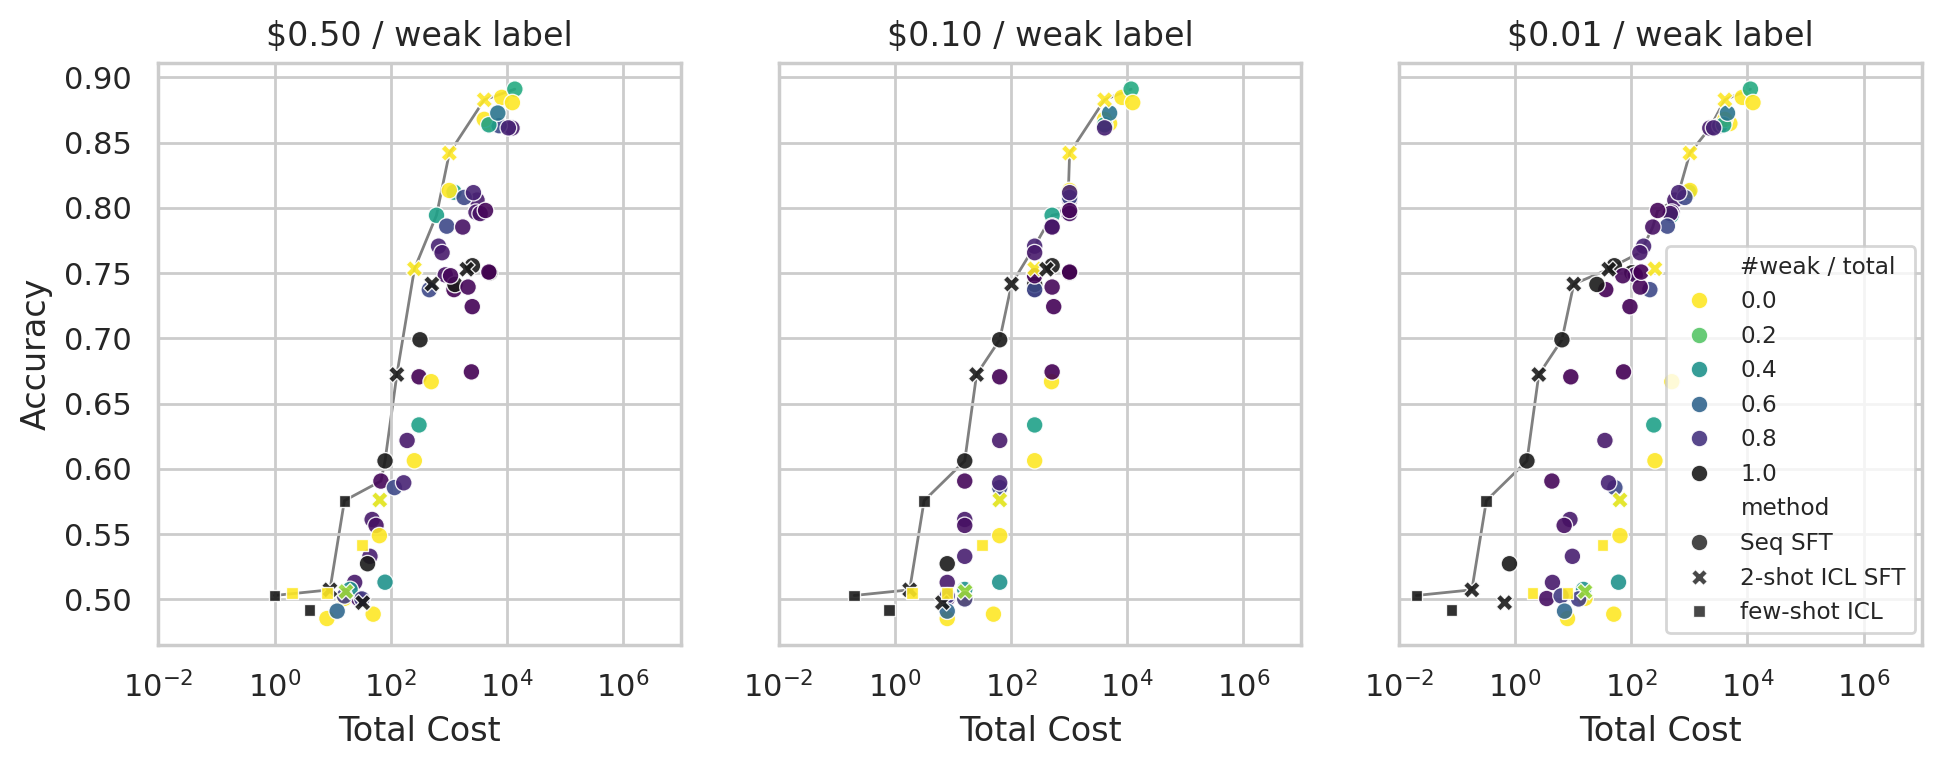

In [34]:
sns.set_theme(style="whitegrid")
sns.set_palette("viridis")

metric = "acc"
weak_model = "Qwen1.5-0.5B"
strong_model = "meta-llama/Meta-Llama-3-8B"

sweep_names = {
    "seq_sft_both_estop_clean_disjoint": "Seq SFT",
    # "seq_sft_both_estop_active_oracle_disjoint": "Seq SFT + uncertainty sampling",
    # "seq_sft_both_estop_disjoint_logconf": "Seq SFT + log-confidence",
    "2weak_prompt_*_sft_estop": "2-shot ICL SFT",
    "few_shot": "few-shot ICL",
}
# weak_spending_fracs = [0.0, 0.05, 0.5, 0.95, 1.0]
# oracle_affordables = [16, 64, 256, 512, 1024, 4096, 8192]
# pairs = []
# for oracle_affordable in oracle_affordables:
#     for wsf in weak_spending_fracs:
#         osf = 1 - wsf
#         n_oracle = int(wsf * oracle_affordable)
#         n_weak = int((oracle_affordable - n_oracle) / weak_marginal_cost)
#         pairs.append((n_weak, n_oracle))

current_ds_names = [f"{base_name}_{weak_model}" for base_name in ["hellaswag", "social_i_qa", "cosmos_qa"]]

weak_marginal_costs = [1/2, 1/10, 1/100]
fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True, dpi=200)
for i, weak_marginal_cost in enumerate(weak_marginal_costs):
    ax = axs[i]
    plt.sca(ax)

    dfs = []
    for sweep_name, label in sweep_names.items():
        accs = []

        # get points from first dataset
        ds_name = current_ds_names[0]
        if sweep_name == "2weak_prompt_*_sft_estop":
            curr_df = results_df.xs((ds_name, strong_model), level=['ds_name', 'model_name'])    
            curr_df = curr_df[curr_df.sweep_name.isin([
                "2weak_prompt_weak_sft_estop",
                "2weak_prompt_oracle_sft_estop",
            ])]
        else:
            curr_df = results_df.xs((ds_name, strong_model, sweep_name), level=['ds_name', 'model_name', 'sweep_name'])
        
        def is_near(p1, p2, rtol=0.05):
            return np.isclose(p1[0], p2[0], rtol=rtol) and np.isclose(p1[1], p2[1], rtol=rtol)
        perfs = dict()
        for pair in zip(curr_df["num_weak"], curr_df["num_oracle"]):
            if any(is_near(pair, p) for p in perfs):
                continue
            perfs[pair] = []
        

        for ds_name in current_ds_names:
            run_name = (ds_name,
                strong_model,
                sweep_name)
            for n_weak, n_oracle in perfs:
                acc, std, n = find_result_by_n(results_df, n_weak, n_oracle, run_name, rtol=0.05, verbose=False)
                # TODO note n, perhaps only keeping large n
                # print(f"{n=}")
                if acc is not None:
                    perfs[(n_weak, n_oracle)].append(acc)

        nw, no, perf = zip(*[[n_weak, n_oracle, np.mean(perfs[(n_weak, n_oracle)])] for n_weak, n_oracle in perfs if len(perfs[(n_weak, n_oracle)]) == len(current_ds_names)])
        
        df = pd.DataFrame({"nw": nw, "no": no, metric: perf})
        df["cost"] = df["nw"] * weak_marginal_cost + df["no"]
        df["weak_spending_frac"] = df["nw"] * weak_marginal_cost / df["cost"]
        df["#weak / total"] = df["nw"] / (df["nw"] + df["no"])
        df["method"] = label
        dfs.append(df)
        
    # Create the scatter plot
    from matplotlib.colors import FuncNorm
    from matplotlib.colors import LinearSegmentedColormap
    import numpy as np

    hue = "#weak / total"
    df = pd.concat(dfs)
    palette = plt.get_cmap('viridis_r').copy()
    palette.set_over('k')
    # Create a new colormap that maps 1.0 to black


    norm = FuncNorm((lambda x: np.log(np.array(x) + 1).tolist(), lambda x: (np.exp(np.array(x)) - 1).tolist()), vmin=0, vmax=df[hue].max() - 1e-6)
    sns.scatterplot(data=df, x='cost', y=metric, hue=hue, alpha=0.9,
                            style='method', palette=palette, ax=ax, hue_norm=norm)

    frontier_costs, frontier_perfs = get_pareto_points(df["cost"], df[metric], cost_rtol=0.05, perf_atol=0.002)
    plt.plot(frontier_costs, frontier_perfs, color="gray", linestyle="-", linewidth=1, zorder=0)

    ax.set_xlim(10**-2, 10**7)
    # ax.invert_xaxis()
    ax.set_xlabel('Total Cost')
    ax.set_ylabel(metric.replace("calibrated_acc", "Calibrated Accuracy").replace("acc", "Accuracy"))
    plt.semilogx()
    if i == 2:
        ax.legend(bbox_to_anchor=(1.01, 0.00), loc='lower right', fontsize='x-small')
    else:
        ax.legend().remove()
    plt.title(f"\\${weak_marginal_cost:.2f} / weak label" )
plt.tight_layout()
plt.savefig(f"_figures/pareto_frontier.pdf", bbox_inches="tight")
plt.show()


# Few shot vs sft

n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=0
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=0
n=1
n=0
n=1
n=1
n=1
n=0
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=0
n=1
n=1
n=1
n=0
n=1


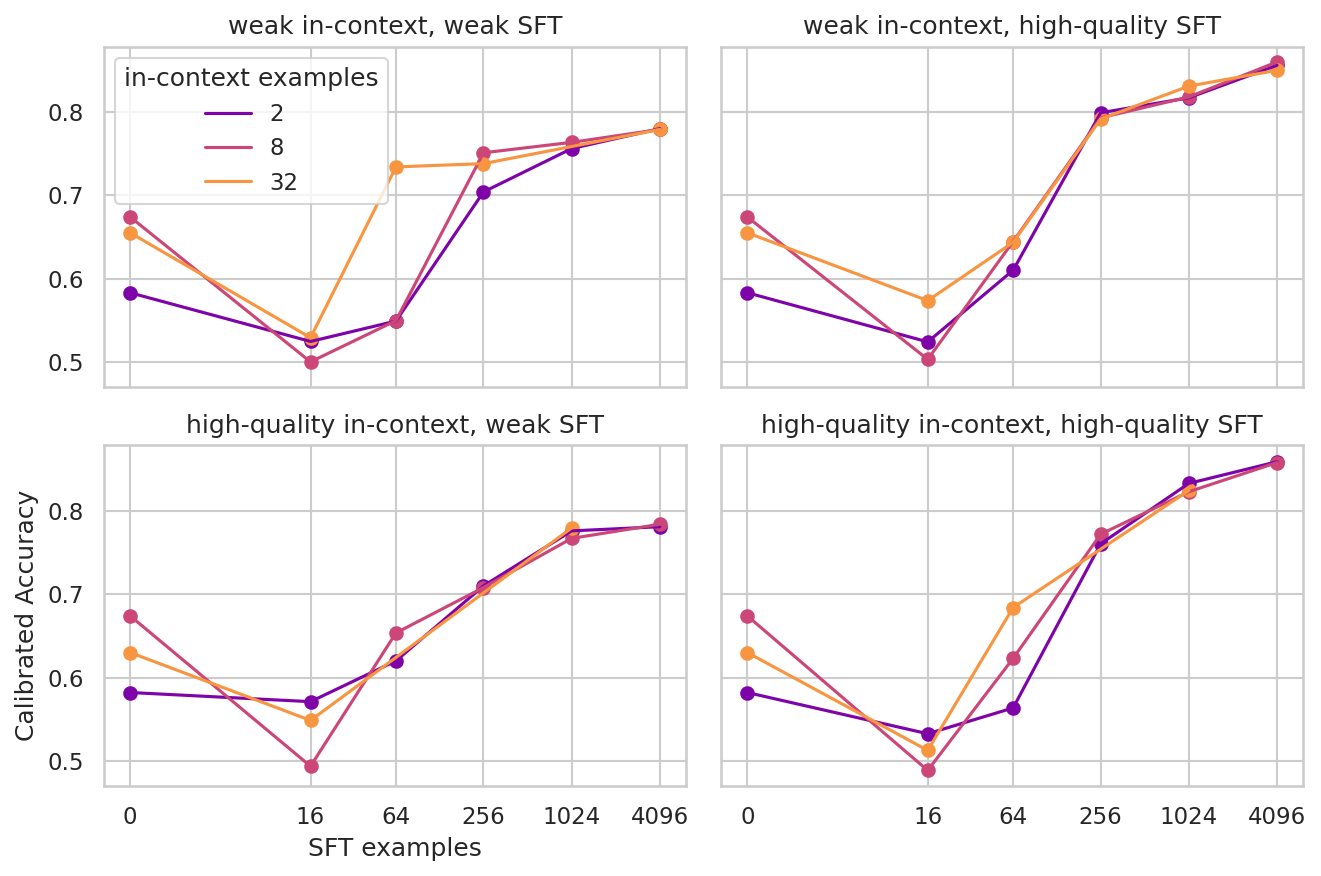

In [74]:
from collections import defaultdict

metric = "calibrated_acc"
weak_model = "Qwen1.5-0.5B"
strong_model = "meta-llama/Meta-Llama-3-8B"

current_ds_names = [f"{name}_{weak_model}" for name in ["cosmos_qa", "social_i_qa"]]
num_few_shots = [2, 8, 32]
sns.set_theme(style="whitegrid")
sns.set_palette("plasma", n_colors=len(num_few_shots))
num_sfts = [0, 16, 64, 256, 1024, 4096]

fig, axs = plt.subplots(2, 2, figsize=(9, 6), sharex=True, sharey=True, dpi=150)
for i, few_shot_type in enumerate(["weak", "oracle"]):
    for j, sft_type in enumerate(["weak", "oracle"]):
        plt.sca(axs[i, j])
        for num_few_shot in num_few_shots:
            accs = []
            plotted_num_sfts = []
            for num_sft in num_sfts:
                nums = defaultdict(int)
                nums[sft_type] += num_sft
                nums[few_shot_type] += num_few_shot

                if num_sft == 0:
                    sweep_name = "few_shot"
                else:
                    sweep_name = f"{num_few_shot}{few_shot_type}_prompt_{sft_type}_sft_estop"

                current_accs = []
                for ds_name in current_ds_names:
                    run_name = (
                        ds_name,
                        strong_model,
                        sweep_name
                    )
                    acc, acc_std, n = find_result_by_n(results_df, nums["weak"], nums["oracle"], run_name, rtol=0.05, verbose=False, metric=metric)
                    print(f"{n=}")
                    current_accs.append(acc)
                if any(ca is None for ca in current_accs):
                    continue
                accs.append(np.mean(current_accs))
                plotted_num_sfts.append(num_sft)
            
            lp1_num_sfts = np.log2(np.array(plotted_num_sfts) + 1)
            plt.plot(lp1_num_sfts, accs, label=f"{num_few_shot}")
            plt.scatter(lp1_num_sfts, accs)

        x_locs = np.log2(np.array(num_sfts) + 1)
        x_labels = [str(round(2**x) - 1) for x in x_locs]
        plt.xticks(x_locs, x_labels)
        plt.gca().set_xticklabels(x_labels)
        
        few_shot_type_name = "high-quality" if few_shot_type == "oracle" else few_shot_type
        sft_type_name = "high-quality" if sft_type == "oracle" else sft_type
        plt.title(f"{few_shot_type_name} in-context, {sft_type_name} SFT")
        if i == 1 and j == 0:
            plt.xlabel("SFT examples")
            plt.ylabel(metric.replace("calibrated_acc", "Calibrated Accuracy").replace("acc", "Accuracy"))
        if i == 0 and j == 0:
            plt.legend(title="in-context examples")
plt.tight_layout()
plt.savefig("_figures/prompt_vs_sft.pdf", bbox_inches="tight")
plt.show()
    

# Qwen1.5 4B (higher quality labels)

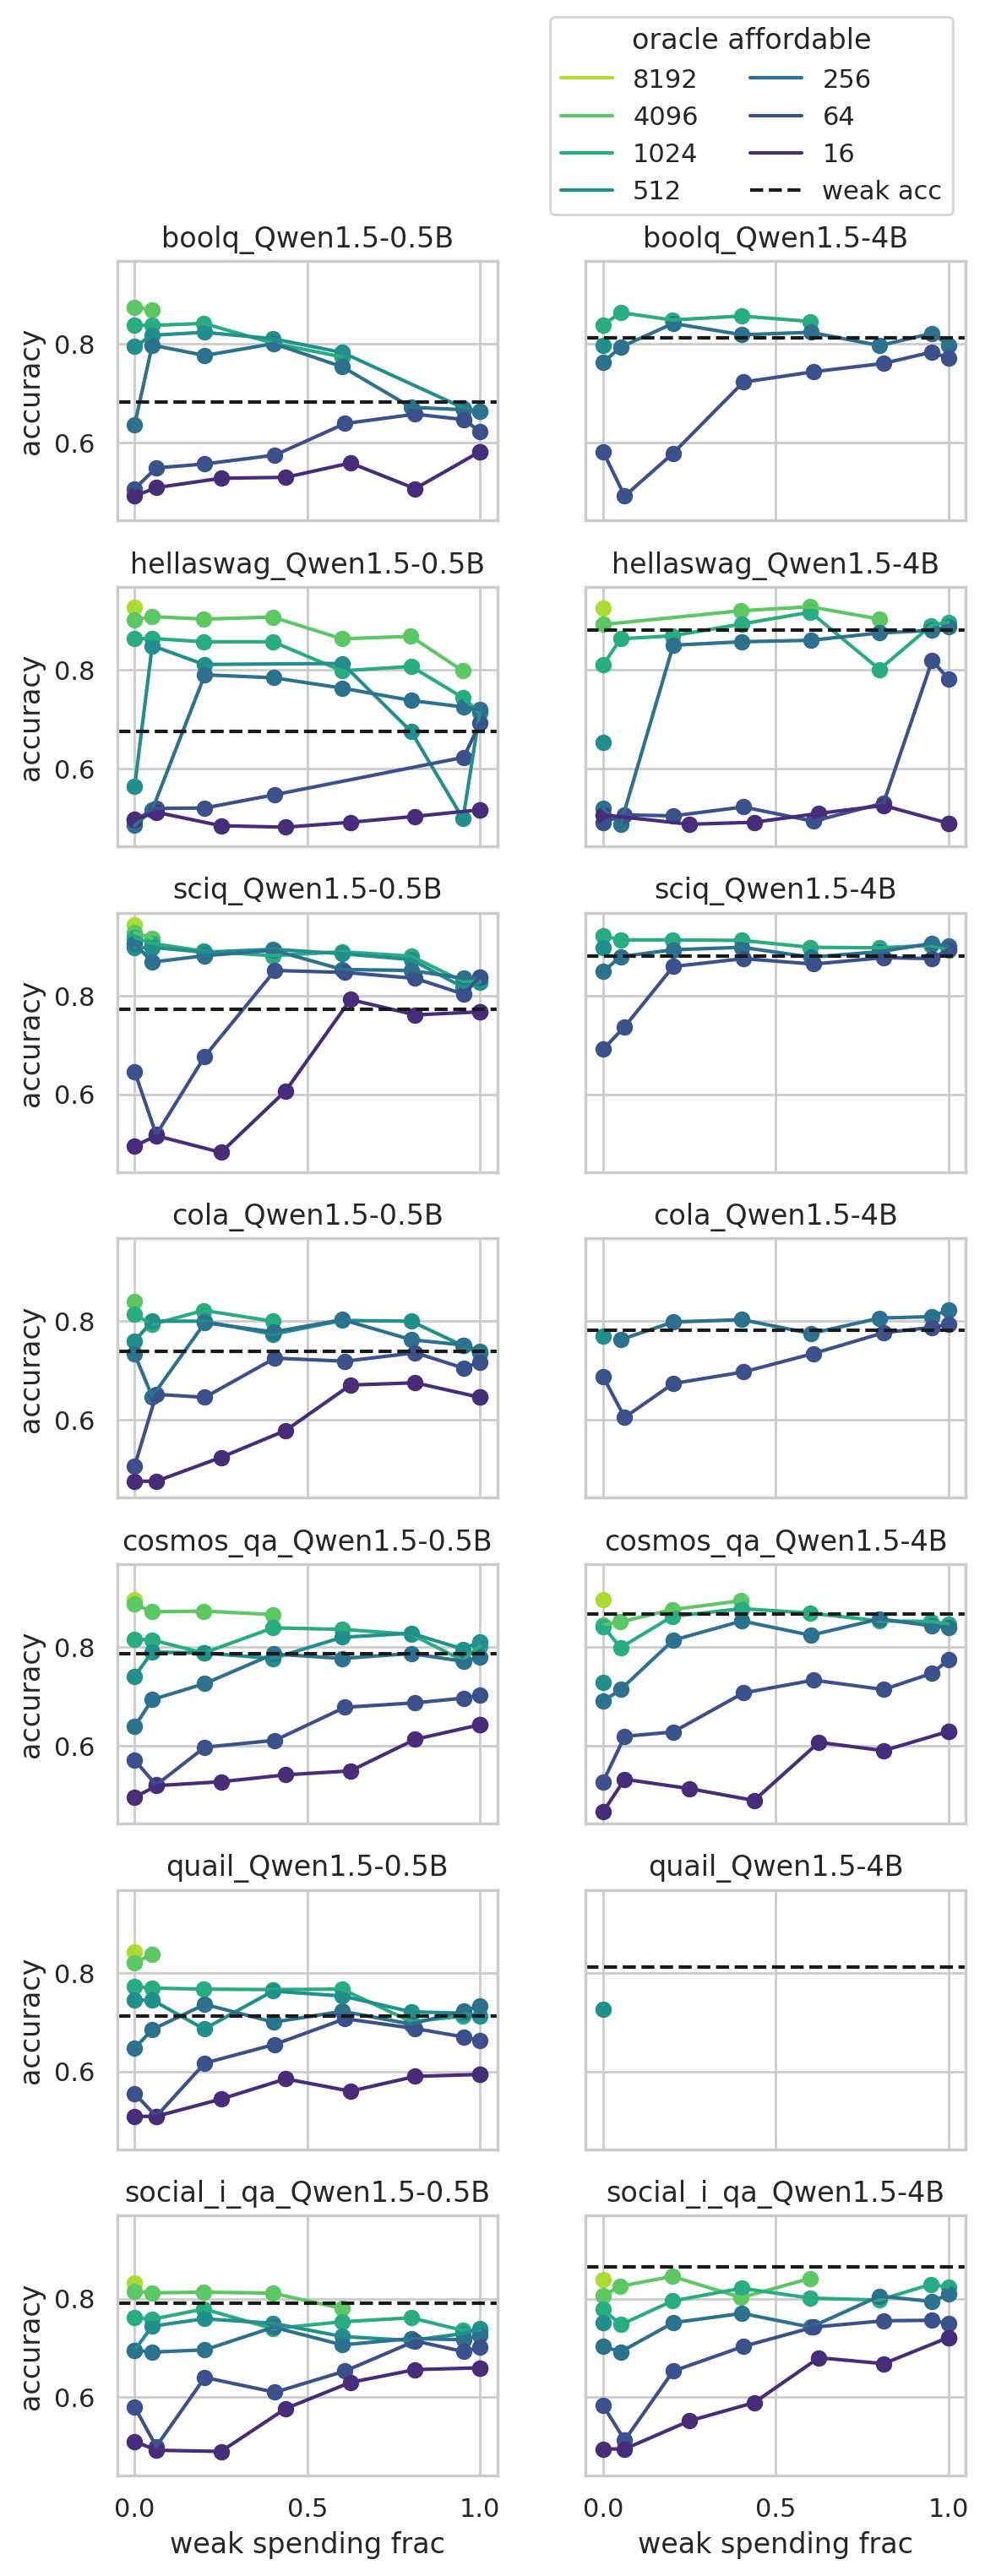

In [57]:
sns.set_theme(style="whitegrid")

weak_marginal_cost = 1/10
strong_model = "meta-llama/Meta-Llama-3-8B"

sweep_name = "seq_sft_both_estop_clean_disjoint"
weak_spending_fracs = [0.0, 0.05, 0.2, 0.4, 0.6, 0.8, 0.95, 1.0]
oracle_affordables = [16, 64, 256, 512, 1024, 4096, 8192]
sns.set_palette("plasma_r", n_colors=len(oracle_affordables))
current_base_ds_names = base_ds_names

kinds = ["{base_name}_" + weak_model for weak_model in ["Qwen1.5-0.5B", "Qwen1.5-4B"]]

fig, axs = plt.subplots(len(current_base_ds_names), len(kinds), figsize=(len(kinds) * 3, 2.2 * len(current_base_ds_names)), sharex=True, sharey=True, dpi=200)
axs = axs.reshape((len(current_base_ds_names), -1))
for i, kind in enumerate(kinds):
    for j, base_ds_name in enumerate(current_base_ds_names):
        plt.sca(axs[j, i])
        ds_name = kind.format(base_name=base_ds_name)
        run_name = (ds_name,
            strong_model,
            sweep_name)
        
        # saliences = salience_df.loc[(ds_name, strong_model)]
        # salience_weak, salience_oracle = saliences["salience_weak"], saliences["salience_oracle"]
        
        for oracle_affordable in oracle_affordables[::-1]:
            accs = []
            actual_wsfs = []
            for wsf in weak_spending_fracs:
                osf = 1 - wsf
                n_oracle = int(wsf * oracle_affordable)
                n_weak = int((oracle_affordable - n_oracle) / weak_marginal_cost)
                acc, acc_std, n = find_result_by_n(results_df, n_weak, n_oracle, run_name, rtol=0.05, verbose=False)
                if acc is not None:
                    accs.append(acc)
                    actual_wsfs.append(1 - (n_oracle / (n_oracle + n_weak * weak_marginal_cost)))
                
            plt.plot(actual_wsfs, accs, label=f"{oracle_affordable}")
            plt.scatter(actual_wsfs, accs)
        
        weak_acc = weak_accs[ds_name]
        plt.axhline(weak_acc, color="k", linestyle="--", label=f"weak acc")
        
        if j == len(current_base_ds_names) - 1:
            plt.xlabel("weak spending frac")
        if i == 0:
            plt.ylabel("accuracy")
        plt.title(f"{ds_name}")
        if i == 1 and j == 0:
            plt.legend(title="oracle affordable", loc="lower right", bbox_to_anchor=(1., 1.13), ncol=2)
# plt.suptitle(f"sweep: {sweep_name}, strong_model: {strong_model}, weak_model: {weak_model}\nweak_marginal_cost: \\${weak_marginal_cost}")
plt.tight_layout()
plt.savefig(f"_figures/qwen4B.pdf", bbox_inches="tight")
plt.show()